In [1]:
import datetime
import gc
import json
import os
import matplotlib.dates as md
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_info_columns', 500)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)

def safe_map(x):
    """Map known addresses to owners"""
    try: return known_addresses[x]
    except: return x

# known addresses
# Mix of whaleAPI labels and manual labels
with open("data/known_addresses.json", 'r') as f:
    known_addresses = json.load(f)
    
### Read & Clean ETH blockchain data
# From https://etherscan.io/address/55fe002aeff02f77364de339a1292923a15844b8#tokentxns
df_list = []
for f in os.listdir("data/usdc"):
    if f.endswith(".csv"):
        df_list.append(pd.read_csv(f"data/usdc/{f}", index_col=False))
df = (
    pd.concat(df_list)
      .reset_index(drop=True)
      .drop_duplicates()
      .sort_values(by="UnixTimestamp")
      .reset_index(drop=True)
)
df['date'] = pd.to_datetime(df.DateTime)
df = df.drop(columns=['DateTime', 'Txhash', 'UnixTimestamp', 'ContractAddress', 'TokenName'])
df.columns = ['from', 'to', 'value', 'token', 'date']
df = df[['date', 'value', 'token', 'from', 'to']]
df['date'] = pd.to_datetime(df.date)
df['day'] = df.date.dt.date
df.to = df.to.apply(safe_map)
df['from'] = df['from'].apply(safe_map)

# Fix numeric values
df.value = pd.to_numeric(
    df.value.astype(str)
      .str.replace(",", "")
)
# Make burns negative
df.loc[df.to == 'null', 'value'] *= -1
# Make backflows negative
df.loc[(df.to == 'usdc') & (df['from'] != 'null'), 'value'] *= -1
df

,date,value,token,from,to,day
0,2021-05-16 00:00:28,4017156.45,USDC,usdc,uniswap/huobi,2021-05-16
1,2021-05-16 00:06:54,2989425.89,USDC,null,usdc,2021-05-16
2,2021-05-16 00:08:48,-30998.27,USDC,usdc,null,2021-05-16
3,2021-05-16 00:09:19,2989410.89,USDC,usdc,uniswap/huobi,2021-05-16
4,2021-05-16 00:14:24,737832.00,USDC,usdc,binance,2021-05-16
...,...,...,...,...,...,...
65690,2021-07-14 17:58:24,2202.74,USDC,usdc,0xbdda0767de1b535535c903912b0c670aa1483a96,2021-07-14
65691,2021-07-14 17:58:44,1659.00,USDC,usdc,0x47b065caf9ab2702876e6c881d6367fa8b3a05eb,2021-07-14
65692,2021-07-14 17:59:50,50.00,USDC,usdc,0xf291e7bdce0a72ec4f13c3ede876ec3ce8e8e05a,2021-07-14
65693,2021-07-14 17:59:50,1445.20,USDC,usdc,0xa269cb9a7818607288bc546ff564acca87196596,2021-07-14


<AxesSubplot:xlabel='to'>

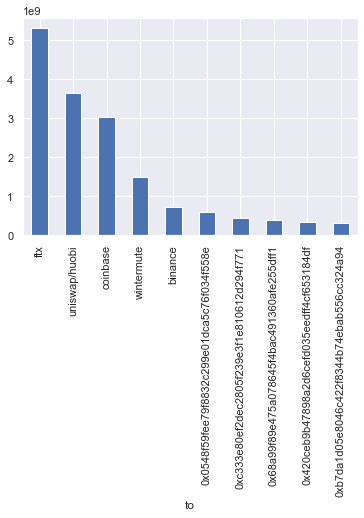

In [2]:
(df.loc[(df['from'] != 'null')]
   .groupby('to')
   .value.sum()
   .sort_values(ascending=False)
   [:10]
).plot(kind='bar')

<AxesSubplot:xlabel='to'>

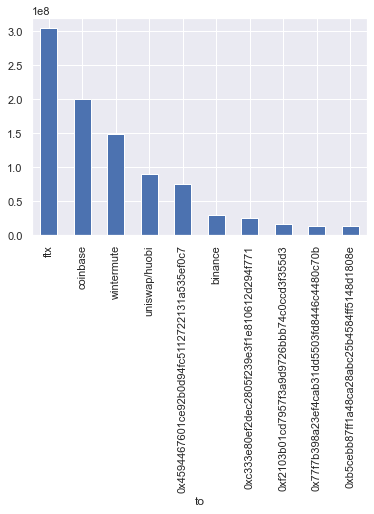

In [3]:
(df.loc[(df.date >= '2021-05-19') 
        & (df.date <= '2021-05-20')
        & (df['from'] != 'null')]
   .groupby('to')
   .value.sum()
   .sort_values(ascending=False)
   [:10]
).plot(kind='bar')

Reverse

In [4]:
(df.loc[~(df['from'].isin(['null', 'usdc']))]
   .groupby('from')
   .value.sum()
   .sort_values(ascending=True)
   [:10]
)

from
usdc burn address                            -2.942184e+09
0x1168e1562ff0733433effe7ca4e14a105bd244e5   -2.548482e+09
coinbase                                     -1.425000e+09
ftx                                          -9.145279e+08
binance                                      -2.281068e+08
0x9468980a06bbd60854f3e52aa7ac16f889e64ae4   -1.714150e+08
0x05e8938a660dcc8bd8cd9acb392062a4b19efde2   -1.710000e+08
0xd178ce741b5b159dbd80277cce51b88c86e07731   -1.267621e+08
0xbe316b3fdaf02eeea098c5e1d3c30fe72506531f   -1.135349e+08
0xbaf184409be67e26b663aa40a977cfa37a8647fe   -1.037203e+08
Name: value, dtype: float64

In [5]:
(df.loc[(df.date >= '2021-05-19') 
        & (df.date <= '2021-05-20')
        & ~(df['from'].isin(['null', 'usdc']))]
   .groupby('from')
   .value.sum()
   .sort_values(ascending=True)
   [:10]
)

from
usdc burn address                            -1.878499e+08
0x1168e1562ff0733433effe7ca4e14a105bd244e5   -3.845858e+07
0xd178ce741b5b159dbd80277cce51b88c86e07731   -2.619992e+07
0x9468980a06bbd60854f3e52aa7ac16f889e64ae4   -1.600000e+07
ftx                                          -8.974531e+06
0x8d9dea136e6cf399ef89a8c65fcdd6c7074ce817   -6.000000e+06
0xbe316b3fdaf02eeea098c5e1d3c30fe72506531f   -4.506604e+06
0xbaf184409be67e26b663aa40a977cfa37a8647fe   -4.195289e+06
0x1c14600cc5040134de833eba667692e359c6edbf   -2.000000e+06
0xa9c338f74203fc888fb2f05cae0682474e047ded   -9.999600e+05
Name: value, dtype: float64

### FTX on May 19th

In [6]:
ftx = pd.read_csv("ftx_19.csv", index_col=False)

ftx['date'] = pd.to_datetime(ftx.DateTime)
ftx = ftx.drop(columns=['DateTime', 'Txhash', 'UnixTimestamp', 'ContractAddress', 'TokenName'])
ftx.columns = ['from', 'to', 'value', 'token', 'date']
ftx = ftx[['date', 'value', 'token', 'from', 'to']]
ftx['date'] = pd.to_datetime(ftx.date)
ftx['day'] = ftx.date.dt.date
ftx.to = ftx.to.apply(safe_map)
ftx['from'] = ftx['from'].apply(safe_map)

# Fix numeric values
ftx.value = pd.to_numeric(
    ftx.value.astype(str)
      .str.replace(",", "")
)
ftx.sample(3)

,date,value,token,from,to,day
2925,2021-05-19 08:51:15,392.473355,USDC,0x60907b6a9a01b03672e3458d814a70839ed99206,ftx,2021-05-19
1677,2021-05-19 05:42:41,14999.975384,USDT,ftx,0xaf894dd97201f1ff194b76be2809a3c43463aaaf,2021-05-19
3952,2021-05-19 12:02:45,1638.000000,LINKBULL,ftx,0x02e1315d289358db5ae89cd325b51542aecab30b,2021-05-19


In [7]:
ftx.loc[ftx.token == 'USDC'].groupby('from').value.sum().sort_values(ascending=False)

from
ftx                                           4.157940e+08
0x8bb8ae077176277cf6192d178e5ad6633561ea44    3.479680e+07
0x59faa16876a0a71fb44054e62a067304071dcea0    2.217691e+07
0xdb75c434513c428b85391393a11c5271f9aa593b    8.999000e+06
0xa16ca674b211eea99a8d2e2130329447253f583a    5.335917e+06
0x5a4d4bfdc35941213531829d37a289c46e57b3a2    5.000000e+06
0x0a8747fec089e8eecefca196b72704cb0d82eeb5    4.000000e+06
0xeb6dd75e53526193255e79f8413b2c9c243dce59    3.438164e+06
0x73af91b303a0cc52fc49d4fdb467f78b047e5426    3.361061e+06
0x68b3f12d6e8d85a8d3dbbc15bba9dc5103b888a4    2.188534e+06
0xde6a388eb612f06d50e9a06f31e2c3165430bf6b    2.000438e+06
0xe67c8d1092eb4d2f121e609490367f88811de828    2.000000e+06
0x3e4eb2f5a459e691752e568b0eef10c99ff18062    1.836323e+06
0xfeff3ac0029a552cacbec49864b47d3ac4a2d19d    1.439911e+06
0x59768d8daff85e7788118f9b58c49391f9ca779b    1.315663e+06
0x478b1ee9cd40330d9c816d8c6be76270f847c0ab    1.055140e+06
0x4c93251abe89ac983a26c53aa2dd1db5cdf82cb4    1.000

NameError: name 'tt' is not defined

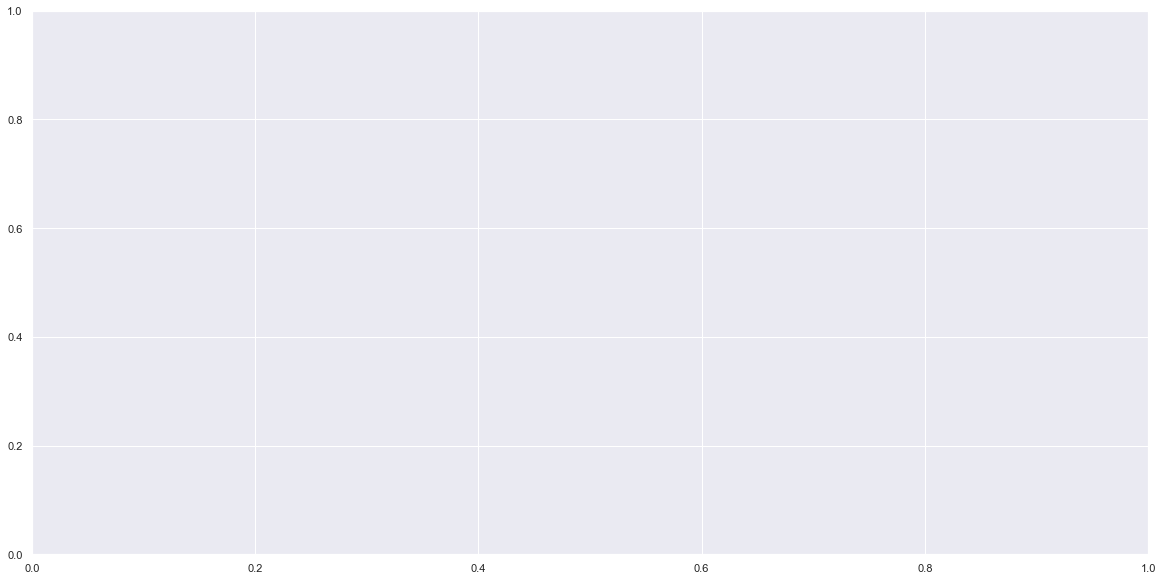

In [8]:
fig, ax = plt.subplots(figsize=(20,10))

sns.barplot(
    data=tt.loc[pd.to_datetime(tt.date) > '2020-10-01'],
    x="date", y='value', 
    hue="direction",
    ax=ax
)
ax.xaxis.set_major_locator(md.WeekdayLocator(byweekday=1, interval=1))
plt.setp(ax.xaxis.get_majorticklabels(), rotation = 90)
plt.show()

In [ ]:
df.loc[(df.direction == 'in') & (df.date >= '2021-05-15')].sort_values(by='value')